# K-fold cross validation - Regression Model
Based on the [Ludwig regression example](https://ludwig-ai.github.io/ludwig-docs/examples/#simple-regression-fuel-efficiency-prediction)  

[Data set](https://archive.ics.uci.edu/ml/datasets/auto+mpg)

This example demonstrates teh following:

- Download a data set and create a pandas dataframe
- Create a training and hold-out test data sets
- Create a Ludwig model definition data structure from the pandas dataframe
- Run a 5-fold cross validation analysis with the training data
- Use Ludwig APIs to train and assess model performance on hold-out test data set

In [1]:
import logging
import os
import os.path
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import scipy.stats as stats
import seaborn as sns
from sklearn.model_selection import train_test_split

from ludwig.api import kfold_cross_validate, LudwigModel

## Contstants

In [2]:
DATA_SET_URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
DATA_SET = 'auto_mpg.data'
RESULTS_DIR = 'results'

## Clean out previous results

In [3]:
if os.path.isfile(DATA_SET):
    os.remove(DATA_SET)
    
shutil.rmtree(RESULTS_DIR, ignore_errors=True)

## Retrieve data from UCI Machine Learning Repository

### Download required data

In [4]:
r = requests.get(DATA_SET_URL)
if r.status_code == 200:
    with open(DATA_SET,'w') as f:
        f.write(r.content.decode("utf-8"))

### Create Pandas DataFrame from downloaded data

In [5]:
raw_df = pd.read_csv(DATA_SET,
                     header=None,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)


raw_df.columns = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'ModelYear', 'Origin']
raw_df.shape

(398, 8)

In [6]:
raw_df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


### Create train/test split

In [7]:
train_df, test_df = train_test_split(raw_df, train_size=0.8, random_state=17)
print(train_df.shape)
print(test_df.shape)

(318, 8)
(80, 8)


## Setup Ludwig model definition

In [8]:
num_features = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'ModelYear']
cat_features = ['Origin']

### Create Ludwig input_features

In [9]:
input_features = []
# setup input features for numerical variables
for p in num_features:
    a_feature = {'name': p, 'type': 'numerical', 
                'preprocessing': {'missing_value_strategy': 'fill_with_mean', 'normalization': 'zscore'}}
    input_features.append(a_feature)

# setkup input features for categorical variables
for p in cat_features:
    a_feature = {'name': p, 'type': 'category'}

### Create Ludwig output features

In [10]:
output_features =[
    {
        'name': 'MPG',
        'type': 'numerical',
        'num_fc_layers': 2,
        'fc_size': 64
    }
]

In [11]:
model_definition = {
    'input_features' : input_features,
    'output_features': output_features,
    'training' :{
        'epochs': 100,
        'batch_size': 32
    }
}
model_definition

{'input_features': [{'name': 'Cylinders',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'Displacement',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'Horsepower',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'Weight',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'Acceleration',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'ModelYear',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}}],
 'output_features': [{'name': 'MPG',
   'type': 'numerical',
   'num_fc_layers': 2,
   'fc_size': 64}

## Perform K-fold Cross Validation analysis

In [12]:
%%time
with tempfile.TemporaryDirectory() as tmpdir:
    data_csv_fp = os.path.join(tmpdir,'train.csv')
    train_df.to_csv(data_csv_fp, index=False)

    (
        kfold_cv_stats, 
        kfold_split_indices 
    ) = kfold_cross_validate(
        num_folds=5,
        model_definition=model_definition,
        data_csv=data_csv_fp,
        output_directory=tmpdir,
        logging_level=logging.ERROR
    )


starting 5-fold cross validation
training on fold 1
CPU times: user 38.7 s, sys: 5.25 s, total: 44 s
Wall time: 39.6 s


In [13]:
kfold_cv_stats['overall']['MPG']

{'loss_mean': 8.389318,
 'loss_std': 2.715054,
 'mean_squared_error_mean': 8.389318,
 'mean_squared_error_std': 2.7150543,
 'mean_absolute_error_mean': 2.076225,
 'mean_absolute_error_std': 0.3013124,
 'r2_mean': 0.86302215,
 'r2_std': 0.03571062,
 'error_mean': -0.025045106,
 'error_std': 0.5639546}

## Train model and assess model performance

In [14]:
model = LudwigModel(
    model_definition=model_definition,
    logging_level=logging.ERROR
)

In [15]:
%%time
training_stats = model.train(
    training_set=train_df,
    output_directory=RESULTS_DIR,
)

CPU times: user 7.46 s, sys: 1.65 s, total: 9.11 s
Wall time: 12.6 s


In [16]:
test_stats, mpg_hat_df, _ = model.evaluate(dataset=test_df, collect_predictions=True, collect_overall_stats=True)

/opt/project/ludwig/data/preprocessing.py:234: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df[feature[NAME]].mean(),
/opt/project/ludwig/data/preprocessing.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprocessing_parameters['fill_value'],


In [17]:
test_stats

{'MPG': {'loss': 8.907557,
  'mean_squared_error': 8.907557,
  'mean_absolute_error': 2.31068,
  'r2': 0.84533125,
  'error': -0.49715215},
 'combined': {'loss': 8.907557}}

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


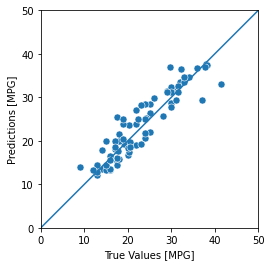

In [18]:
a = plt.axes(aspect='equal')
sns.scatterplot(test_df['MPG'].values, mpg_hat_df['MPG_predictions'].values,
               s=50)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


## Compare K-fold Cross Validation metrics against hold-out test metrics

### Hold-out Test Metrics

In [19]:
test_stats['MPG']

{'loss': 8.907557,
 'mean_squared_error': 8.907557,
 'mean_absolute_error': 2.31068,
 'r2': 0.84533125,
 'error': -0.49715215}

### K-fold Cross Validation Metrics

In [20]:
kfold_cv_stats['overall']['MPG']

{'loss_mean': 8.389318,
 'loss_std': 2.715054,
 'mean_squared_error_mean': 8.389318,
 'mean_squared_error_std': 2.7150543,
 'mean_absolute_error_mean': 2.076225,
 'mean_absolute_error_std': 0.3013124,
 'r2_mean': 0.86302215,
 'r2_std': 0.03571062,
 'error_mean': -0.025045106,
 'error_std': 0.5639546}